Data used:

- Crop fields (Basisregistratie Gewaspercelen): https://www.pdok.nl/introductie/-/article/basisregistratie-gewaspercelen-brp-

- Dikes (BRO Geomorfologische Kaart van Nederland 2019 V1): https://www.pdok.nl/downloads/-/article/basisregistratie-ondergrond-bro-#fa90454e447b478fb2db187bb6fc8a10
Manually exclude irrelevant layers and crop data with QGIS to the AoI

- Groud water monitoring well (BRO Grondwatermonitoringnet):
https://www.pdok.nl/downloads/-/article/basisregistratie-ondergrond-bro-#3f9edb6734c11af4886cdb37b69711bc
Manually exclude irrelevant layers and crop data with QGIS to the AoI

### Preparation (optional): crop the field polygons to the AoI

Can potentially be a part of the vector data handling episode? 

In [1]:
import geopandas as gpd

# Load all crop field boundaries (brpgewaspercelen)
# Data downloaded from: https://service.pdok.nl/rvo/brpgewaspercelen/atom/v1_0/downloads/brpgewaspercelen_definitief_2020.gpkg
cf_boundary = gpd.read_file("../data/data/brpgewaspercelen_definitief_2020.gpkg")

print(cf_boundary)

        category                                         gewas  gewascode  \
0       Grasland                            Grasland, blijvend        265   
1       Bouwland                               Bieten, suiker-        256   
2       Grasland                            Grasland, blijvend        265   
3       Grasland                            Grasland, blijvend        265   
4       Grasland  Grasland, natuurlijk. Hoofdfunctie landbouw.        331   
...          ...                                           ...        ...   
619994  Bouwland                                   Maïs, snij-        259   
619995  Bouwland                                   Maïs, snij-        259   
619996  Bouwland                                   Maïs, snij-        259   
619997  Bouwland                                   Maïs, snij-        259   
619998  Grasland                           Grasland, tijdelijk        266   

        jaar   status                                           geometry  


In [2]:
# Define Boundingbox in RD
xmin, xmax = (120000, 135000)
ymin, ymax = (485000, 500000)
cf_boundary_crop = cf_boundary.cx[xmin:xmax, ymin:ymax]   

<AxesSubplot:>

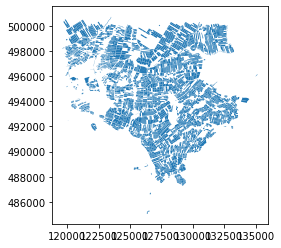

In [3]:
cf_boundary_crop.plot()

In [4]:
cf_boundary_crop.to_file("../data/crop_fields/cf_boundary_crop.shp")

/home/ouku/miniconda3/envs/geospatial_python/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


### Preparation: Retrive S2 data within the same AoI, on a given time period

Can potentially contribute to the data access episode

In [10]:
import geopandas as gpd
from shapely.geometry import box

# Load the saved shape 
cf_boundary_crop = gpd.read_file("../data/crop_fields/cf_boundary_crop.shp")

# Counvert bbox to WGS84 for searching
gdf_bbox = gpd.GeoDataFrame(index=[0], geometry=[box(*cf_boundary_crop.total_bounds)], crs=cf_boundary_crop.crs)
gdf_bbox = gdf_bbox.to_crs(4326) # WGS84 is thed fault specification for STAC catalogs

In [11]:
from pystac_client import Client

# Specify the catalog and seaching period
api_url = "https://earth-search.aws.element84.com/v0"
collection = "sentinel-s2-l2a-cogs" # collection: Sentinel-2, Level 2A, COGs
period = "2020-05-01/2020-05-30"

# Build client
client = Client.open(api_url)

# Search
mysearch = client.search(
    collections=[collection],
    bbox=gdf_bbox.total_bounds,
    datetime= period,
    query=['eo:cloud_cover<5']
)

In [12]:
print(mysearch.matched())

2


In [13]:
# Export search results
items = mysearch.get_all_items()
items.save_object("../data/search_results.json")

dict_keys(['thumbnail', 'overview', 'info', 'metadata', 'visual', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12', 'AOT', 'WVP', 'SCL'])

## Episode crop raster

### Crop image to the AoI

Original data downloaded from: https://service.pdok.nl/rvo/brpgewaspercelen/atom/v1_0/downloads/brpgewaspercelen_definitief_2020.gpkg. Cropped with a given extent. See previous episodes.

In [1]:
import rioxarray
import geopandas as gpd
from pystac import ItemCollection

# Load image with href
items = ItemCollection.from_file('../data/search_results.json')
raster_href = items[0].assets["visual"].href
raster = rioxarray.open_rasterio(raster_href)

# Load the boundaries of the crop fields
cf_boundary_crop = gpd.read_file("../data/crop_fields/cf_boundary_crop.shp")
cf_boundary_crop = cf_boundary_crop.to_crs(raster.rio.crs) # use the original gdf for all polygons

In [2]:
# Crop with the bounding box of all fields
raster_clip = raster.rio.clip_box(*cf_boundary_crop.total_bounds)

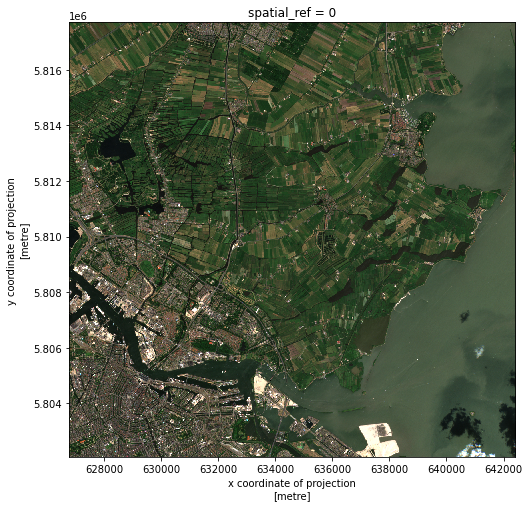

In [3]:
raster_clip.plot.imshow(figsize=(8,8))

### Crop with the polygon of fields

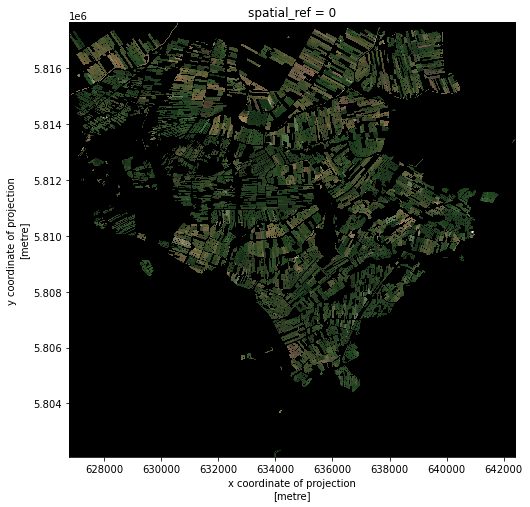

In [28]:
# Crop
raster_clip_fields = raster_clip.rio.clip(cf_boundary_crop['geometry'], cf_boundary_crop.crs)

# Load the saved shape 
cf_boundary_crop = gpd.read_file("../data/crop_fields/cf_boundary_crop.shp")

# Visualize
raster_clip_fields.plot.imshow(figsize=(8,8))

### Crop with buffer around the dike



<AxesSubplot:>

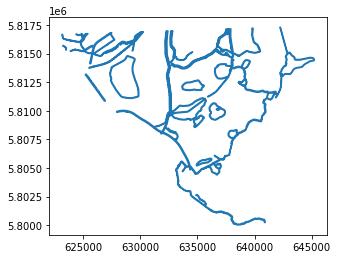

In [59]:
# Load dikes
dikes = gpd.read_file("../data/dikes/dikes.shp")
dikes = dikes.to_crs(raster.rio.crs)
dikes.plot()

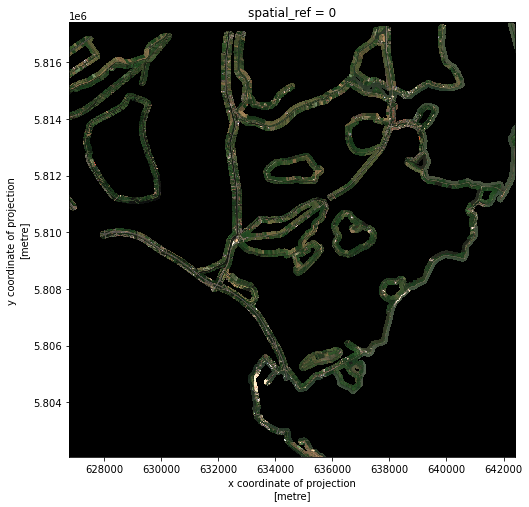

In [55]:
# Dike buffer
dikes_buffer = dikes.buffer(100)

# Crop
raster_clip_dikes = raster_clip.rio.clip(dikes_buffer, dikes_buffer.crs)

# Visualize
raster_clip_dikes.plot.imshow(figsize=(8,8))

### Crop to the buffer of groundwater monitoring wells

<AxesSubplot:>

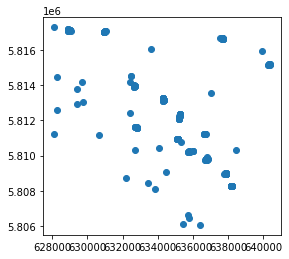

In [57]:
# Load wells
wells = gpd.read_file("../data/groundwater_monitoring_well/groundwater_monitoring_well.shp")
wells = wells.to_crs(raster.rio.crs)
wells.plot()

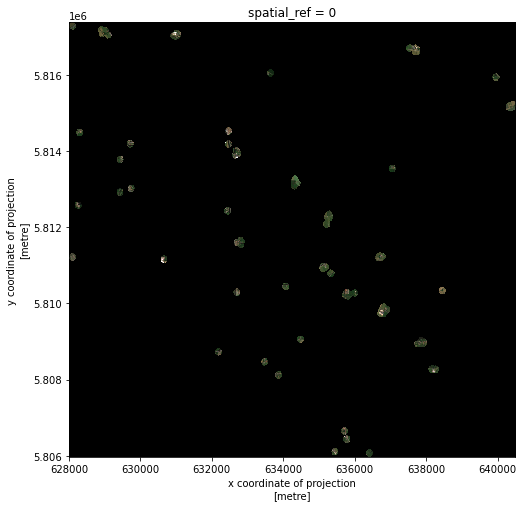

In [58]:
# Create Buffer
wells_buffer = wells.buffer(100)

# Crop
raster_clip_wells = raster_clip.rio.clip(wells_buffer, wells_buffer.crs)

# Visualize
raster_clip_wells.plot.imshow(figsize=(8,8))